In [54]:
import pandas as pd
import numpy as np
from numpy import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
#from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [55]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [56]:
train_anno=pd.read_json('/kaggle/input/penguins-vs-turtles/train_annotations')
train_anno.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,2,"[225, 298, 198, 185]",36630,[],0
3,3,3,2,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


In [57]:
# lets see how many classes are present in the category id
classes=list(train_anno['category_id'].unique())
print (classes)
# for image_id 0 image is of a penguin so class 1 indicates a penguin, class 2 indicates a turtle
# I will not be using columns id, bbox, area, segmentation or iscrowd so lets delete the columns
train_anno=train_anno.drop(['id', 'bbox', 'area', 'segmentation', 'iscrowd'], axis =1)
# lets replace the numeric class designation with the test name of the class
train_anno['category_id']=train_anno['category_id'].replace({1:'Penguin',2:'Turtle'})
print (train_anno.head())
# I want to create a dataframe with 2 columns filepaths and labels where the entries in the filepaths
# column is the full path to the image file and the entries in the labels column is the text label of
# of the class
# first lets change the column names
train_anno.columns=['filepaths', 'labels']
print(train_anno.head())
# now in the filepaths column create the full path to the image file
train_image_dir=r'/kaggle/input/penguins-vs-turtles/train/train'
train_imglist=sorted(os.listdir(train_image_dir))
train_paths=[]
for i in range (len(train_imglist)):
    train_paths.append(os.path.join(train_image_dir, train_imglist[i]))    
print (train_paths[0])
# now in the train_anno filepaths column insert the full filepath
train_anno['filepaths']=train_paths
print (train_anno.head())

[1, 2]
   image_id category_id
0         0     Penguin
1         1     Penguin
2         2      Turtle
3         3      Turtle
4         4     Penguin
   filepaths   labels
0          0  Penguin
1          1  Penguin
2          2   Turtle
3          3   Turtle
4          4  Penguin
/kaggle/input/penguins-vs-turtles/train/train/image_id_000.jpg
                                                        filepaths   labels
0  /kaggle/input/penguins-vs-turtles/train/train/image_id_000.jpg  Penguin
1  /kaggle/input/penguins-vs-turtles/train/train/image_id_001.jpg  Penguin
2  /kaggle/input/penguins-vs-turtles/train/train/image_id_002.jpg   Turtle
3  /kaggle/input/penguins-vs-turtles/train/train/image_id_003.jpg   Turtle
4  /kaggle/input/penguins-vs-turtles/train/train/image_id_004.jpg  Penguin


In [58]:
# Do the same for the valid annotations
valid_df=pd.read_json('/kaggle/input/penguins-vs-turtles/valid_annotations')
valid_df=valid_df.drop(['id', 'bbox', 'area', 'segmentation', 'iscrowd'], axis =1)
# lets replace the numeric class designation with the test name of the class
valid_df['category_id']=valid_df['category_id'].replace({1:'Penguin',2:'Turtle'})
valid_df.columns=['filepaths', 'labels']
# now in the filepaths column create the full path to the image file
valid_image_dir=r'/kaggle/input/penguins-vs-turtles/valid/valid'
valid_imglist=sorted(os.listdir(valid_image_dir))
valid_paths=[]
for i in range (len(valid_imglist)):
    valid_paths.append(os.path.join(valid_image_dir, valid_imglist[i]))
valid_df['filepaths']=valid_paths
print (valid_df.head())

                                                        filepaths   labels
0  /kaggle/input/penguins-vs-turtles/valid/valid/image_id_000.jpg  Penguin
1  /kaggle/input/penguins-vs-turtles/valid/valid/image_id_001.jpg   Turtle
2  /kaggle/input/penguins-vs-turtles/valid/valid/image_id_002.jpg   Turtle
3  /kaggle/input/penguins-vs-turtles/valid/valid/image_id_003.jpg  Penguin
4  /kaggle/input/penguins-vs-turtles/valid/valid/image_id_004.jpg  Penguin


In [59]:
# lets create a test data frame by splitting the train_anno dataframe into a train dataframe and a test data frame
train_df, test_df=train_test_split(train_anno, train_size=.8, shuffle=True, random_state=123,
                                   stratify=train_anno['labels'])
print ('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df lenght:  400   test_df length:  100   valid_df length:  72


In [60]:
# lets check the balance of labels in the dataset
balance=list(train_df['labels'].value_counts())
print (balance)

[200, 200]


In [61]:
# the train set is balance and has an adequate number of images for classification
# lets create generators for the three dataframes
img_size=(224,224) # image size
bs=40 # batch size
t_gen=ImageDataGenerator(horizontal_flip=True) # generator for training
gen=ImageDataGenerator() # generator for validation and test 
train_gen=t_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   color_mode='rgb',batch_size=bs, shuffle=True, seed=123,
                                   class_mode= 'categorical')
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   color_mode='rgb',batch_size=bs, shuffle=False, seed=123,
                                   class_mode= 'categorical')
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   color_mode='rgb',batch_size=bs, shuffle=False, seed=123,
                                   class_mode= 'categorical')

Found 400 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [62]:
# I will use transfer learning using the EfficientNetB0 model
class_count=2 # number of classes
lr= .001 # learning rate
img_shape=(224,224,3) # shape of color images
base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",
                                                   input_shape=img_shape, pooling='max')        
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [63]:
# lets define 2 callbacks , reduce learning rate on plateau and early stopping
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4,  patience=2,
                                            verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4,restore_best_weights=True)
callbacks=[rlronp, estop]

In [64]:
# now lets train the model
epochs=20
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model

Epoch 1/20


2023-06-03 13:34:00.772454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 48s 515ms/step - loss: 7.7800 - accuracy: 0.8325 - val_loss: 9.5722 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 3s 284ms/step - loss: 6.7814 - accuracy: 0.9825 - val_loss: 8.2672 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 3s 283ms/step - loss: 6.1211 - accuracy: 0.9975 - val_loss: 6.9541 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 3s 328ms/step - loss: 5.5886 - accuracy: 0.9900 - val_loss: 6.0405 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 3s 287ms/step - loss: 5.1284 - accuracy: 0.9825 - val_loss: 5.4684 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 3s 295ms/step - loss: 4.6891 - accuracy: 1.0000 - val_loss: 4.9968 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 3s 291ms/step - loss: 4.3492

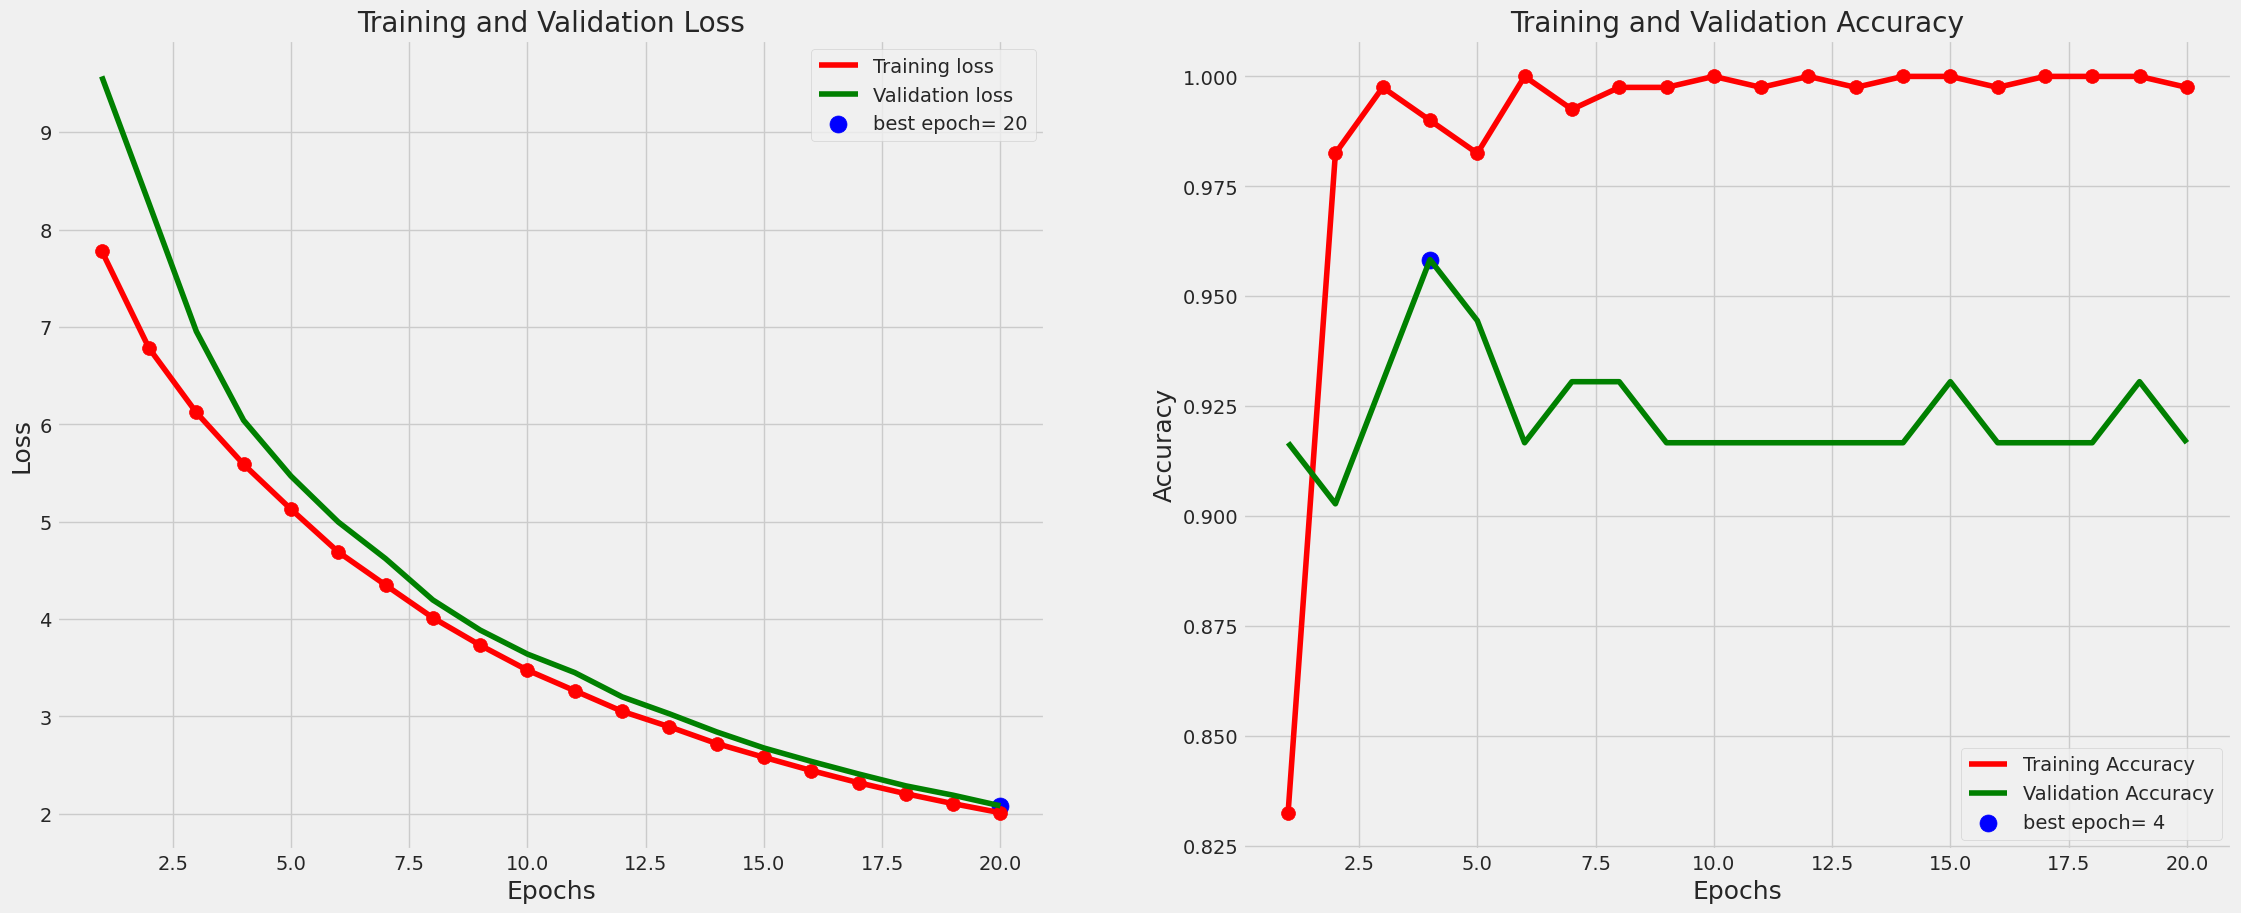

In [65]:
# lets define a function to plot the training data
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']      
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]    
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)     
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()    
    plt.tight_layout    
    plt.show()
    return 

tr_plot(history)


3/3 [==============================] - 0s 104ms/step
There were 2 errors in 100 tests for an accuracy of  98.00 and an F1 score of  98.00


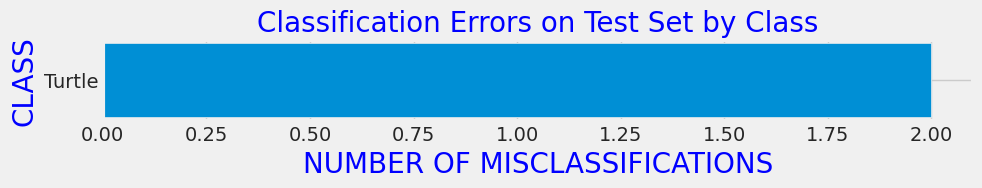

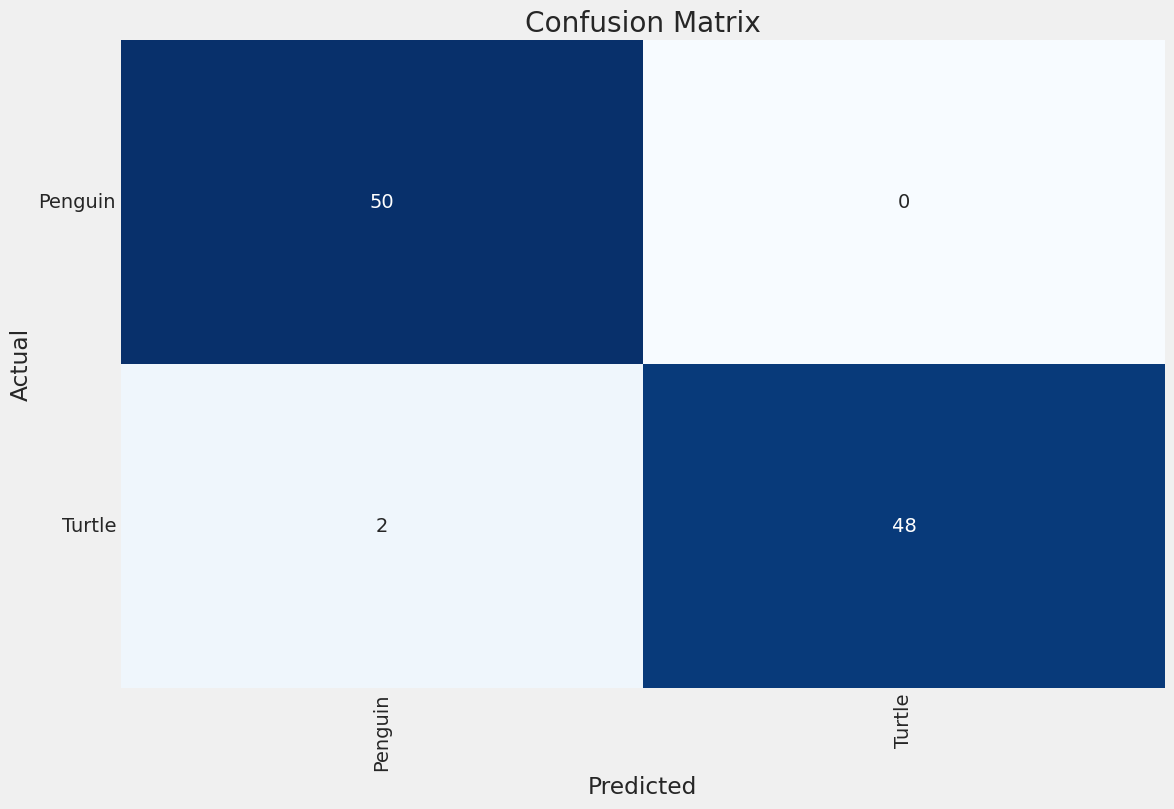

Classification Report:
----------------------
               precision    recall  f1-score   support

     Penguin     0.9615    1.0000    0.9804        50
      Turtle     1.0000    0.9600    0.9796        50

    accuracy                         0.9800       100
   macro avg     0.9808    0.9800    0.9800       100
weighted avg     0.9808    0.9800    0.9800       100



In [71]:
# we ended up with a validation accuracy of 97.2 % so the model is performing well
# lets make predictions on the test set and produce a confusion matrix and a classification report
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score, misclassified_files

f1score, misclassified_files= predictor(model,test_gen)

### In 100 tests we had only 2 errors so the accuracy on the test set was 98 %

In [72]:
# Lets save the model
def save_model(model,subject, classes, img_size, f1score, working_dir):    
    name=f'{subject}-{str(len(classes))}-({str(img_size[0])} X {str(img_size[1])})- {f1score:5.2f}.h5'    
    model_save_loc=os.path.join(working_dir, name)
    try:
        model.save(model_save_loc)        
        msg= f'model was saved as {model_save_loc}'
        
    except:
        msg='model can not be saved due to tensorflow 2.10.0 or higher due to bug for efficientnet models' 
    print (msg)
subject='penguins vs turtles'
working_dir=r'/kaggle/working/'
save_model(model,subject, classes, img_size, f1score, working_dir)

model was saved as /kaggle/working/penguins vs turtles-2-(224 X 224)- 98.00.h5
